# How to: Poisson Regression Model
## By Ximena Sandoval 

### Import the modules we will need

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal
plt.rcParams['figure.figsize'] = (16,8)
plt.style.use('ggplot')

### Let's generate some data to work with!
Remember, we are working with the Poisson regression model, so it makes sense we generate data from a Poisson distribution, right?

(This may be obvious but it took me like 2 hours to realize this when the algorith wasn't working haha)

We will need a matrix $X$ with dimensions $(M,n)$ and a vector of outcomes $Y$
$$
X = 
\begin{pmatrix}
x^{(1)}_1 & x^{(1)}_2 & \ldots & x^{(1)}_n \\
x^{(2)}_1 & x^{(2)}_2 & \ldots & x^{(2)}_n \\
\vdots & \vdots & \ddots & \vdots \\ 
x^{(M)}_1 & x^{(M)}_2 & \ldots & x^{(M)}_n
\end{pmatrix}
\ \ \ \ \ \ \ 
Y = 
\begin{pmatrix}
y^{(1)} \\
y^{(2)} \\
\vdots \\
y^{(M)} 
\end{pmatrix}
$$

Remember we are trying to find a vector of features $w$ and a bias $b$
$$
w =
\begin{pmatrix}
  w_1 \\
  w_2 \\
  \vdots \\
  w_n
\end{pmatrix}
\ \ \ \ \ \ \ \
b
$$


For this notebook I'll be using $M = 10,000$ and $n = 3$.
Now let's generate data that we know the values from the parameters, in this case I'll will be using the following 
$$
w =
\begin{pmatrix}
  0.15 \\
  0.5 \\
  0.2
\end{pmatrix}
\ \ \ \ \ \ \ \
b = 2.0
$$
And finally we calculate:

- Each $x^{(i)}_j$ will come from a normal distribution $N(\mu = 0.0, \sigma=1.0)$ 
- Each $y^{(i)}$ will come from the operation $e^{(X w + b)}$


In [2]:
np.random.seed(37)
sns.color_palette("Set2", as_cmap=True)

M = 10_000
x = np.hstack([
    normal(0.0, 1.0, M).reshape(M, 1),
    normal(0.0, 1.0, M).reshape(M, 1),
    normal(0.0, 1.0, M).reshape(M, 1)
])
z = np.dot(x, np.array([0.15, 0.5, 0.2])) + 2.0 + normal(0.0, 1.0, M)
y = np.exp(z)

Let's pretend we don't know the values for $w$ or $b$ (or else this would not be interesting)

Now let's plot these data so we now everything looks nice

Text(0, 0.5, 'probability')

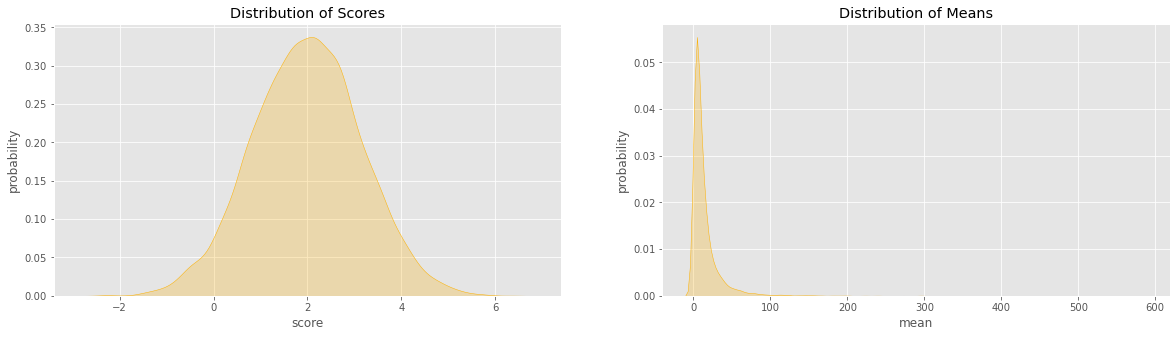

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.kdeplot(z, ax=ax[0], color='#fcb103', shade=True)
ax[0].set_title(r'Distribution of Scores')
ax[0].set_xlabel('score')
ax[0].set_ylabel('probability')

sns.kdeplot(y, ax=ax[1], color='#fcb103', shade=True)
ax[1].set_title(r'Distribution of Means')
ax[1].set_xlabel('mean')
ax[1].set_ylabel('probability')


So far so good, now we can start working with this data!

### The $loss$ function
If we want to find the best $w$ and $b$ we need some way to know how good the ones we have are, that is why we use the $loss$ function which we found in my blog post **wink wink**, and we know 
$$loss = \frac{1}{M} \sum^{M}_{i = 1}\hat{y}^{(i)} - log(\hat{y}^{(i)})y^{(i)}$$

But we also know it's better to do this in a matricial way, so we will do it as it follows

In [4]:
def loss(x, y, w, b):
    y_hat = np.exp(x @ w + b)
    error = (y_hat - np.log(y_hat) * y).mean()
    return error
        

### Gradient Descent Algorithm
Alright! Now we can start talking about the Gradient Descent algorithm first we need to find the gradient with respect $w$ and $b$, which we also talked about in my blog **wink wink**. 

Anyways, we found that we can calculate the gradient as 
$$
  \nabla w = \frac{1}{M} \sum^{M}_{i=1} x^{(i)}(\hat{y}^{(i)} - y^{(i)}) \Rightarrow \frac{1}{M} X(\hat{Y} - Y)
$$
$$
  \nabla b = \frac{1}{M} \sum^{m}_{i=1} \hat{y}^{(i)} - y^{(i)} \Rightarrow \frac{1}{M} (\hat{Y} - Y)
$$

And thus, let us code the `batch_gradient_descent` algorithm


In [5]:
def grad(x, y, w, b):
    M, n = x.shape
    y_hat = np.exp(x @ w + b)
    dw = (x.T @ (y_hat - y)) / M
    db = (y_hat - y).mean()
    return dw, db

def gradient_descent(x, y, w_0, b_0, alpha, num_iter):
    w, b = w_0.copy(), b_0
    hist = np.zeros(num_iter)
    M, n = x.shape
    
    for iter in range(num_iter):
        dw, db = grad(x, y, w, b)
        w -= alpha * dw 
        b -= alpha * db
        hist[iter] = loss(x, y, w, b)

    return w, b, hist

### The moment of truth
Oh boi, it's time to try to find the best $w$ and $b$ for our problem (which then again, we *don't know* **wink wink**).

We will start with a $w_0 = \vec{0}$ and $b_0 = 0$, and let us run our function `gradient_descent`!

For alpha we set $\alpha = 0.01$ and we will run it with $1000$ iterations (you could play with these values too!) 

In [6]:
M, n = x.shape
w_0 = np.zeros((n, ))
b_0 = 0
alpha = 0.01
w, b, hist = gradient_descent(x, y, w_0, b_0, alpha, num_iter=1000)



Finally, I'll plot the evolution of the loss function with each iteration, so we can be certain it's decreasing.
Also, check the values we found for $w$ and $b$! They are pretty similar to the ones we set at the beginning!

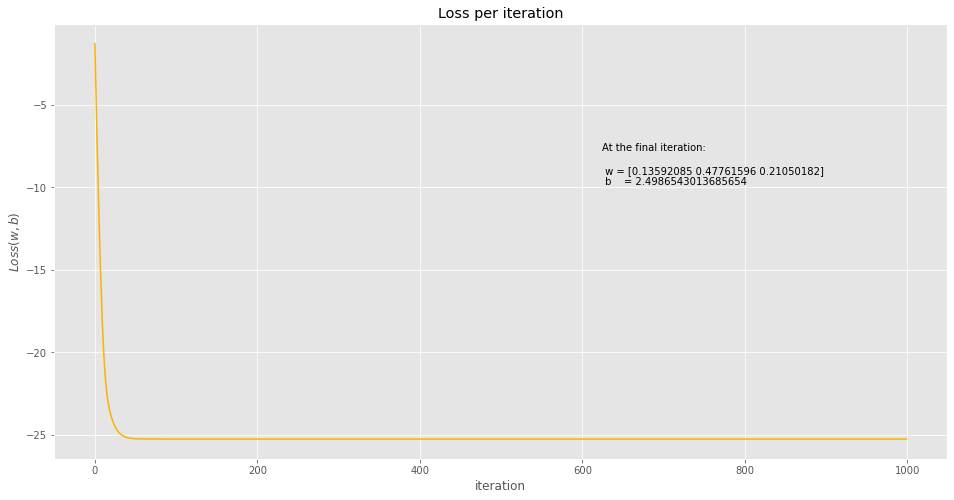

In [7]:
plt.plot(hist, 'b', color='#fcb103')
plt.title(u'Loss per iteration')
plt.xlabel(u'iteration')
plt.ylabel(r'$Loss(w, b)$')
plt.figtext(x=.6, y=.6, s="At the final iteration:\n\n w = {}\n b    = {}".format(w, b))
plt.show()

In [8]:
print(f"The final values for w = {w}")
print(f"The final value for b = {b}")


The final values for w = [0.13592085 0.47761596 0.21050182]
The final value for b = 2.4986543013685654


### Yay! We are done!
Thank you for checking this Jupyter Notebook! I'll see you around ✨ 